# Preprocessing

##  Preprocess weather data

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read in weather csv
weather_df = pd.read_csv('../uploaded_weather_data/weather_data.csv')
weather_df.count()

STATION    6695
DATE       6695
DEW        6695
WND        6695
TMP        6695
dtype: int64

### Drop rows with missing weather values

In [4]:
# assign NA for containing missing values (+9999, 999) 
weather_df_clean = weather_df.replace(r'9999', np.NaN, regex=True)
weather_df_clean2 = weather_df_clean.replace(r'999', np.NaN, regex=True)

# drop any rows containing NaN
weather_df_clean3 = weather_df_clean2.dropna()
weather_df_clean3.count()

STATION    6247
DATE       6247
DEW        6247
WND        6247
TMP        6247
dtype: int64

In [5]:
weather_df_clean3.head()

,STATION,DATE,DEW,WND,TMP
0,74486094789,2018-10-01T00:00:00,"+0150,1","180,1,N,0036,1","+0183,1"
1,74486094789,2018-10-01T00:51:00,"+0150,5","190,5,N,0041,5","+0183,5"
2,74486094789,2018-10-01T01:51:00,"+0156,5","190,5,N,0041,5","+0183,5"
3,74486094789,2018-10-01T02:51:00,"+0161,5","200,5,N,0051,5","+0189,5"
4,74486094789,2018-10-01T03:00:00,"+0161,1","200,1,N,0051,1","+0189,1"


### Obtain important weather features

In [6]:
# keep date and remove time
weather_df_clean4 = weather_df_clean3.replace({'DATE': r'T.{8}'}, '', regex=True)

# keep dew point and remove dew point code
weather_df_clean5 = weather_df_clean4.replace({'DEW': r',\d$'}, '', regex=True)

# keep wind speed and remove other wind data
weather_df_clean6 = weather_df_clean5.replace({'WND': r',\d$'}, '', regex=True)
weather_df_clean7 = weather_df_clean6.replace({'WND': r'.{8}'}, '', regex=True)

# keep air temperature and remove air temperature code
weather_df_final = weather_df_clean7.replace({'TMP': r',\d$'}, '', regex=True)


In [7]:
# save final weather data as parquet
weather_df_final.to_parquet('../data/raw/weather_data.parquet')

In [8]:
from pyspark.sql import SparkSession

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

22/08/20 11:43:00 WARN Utils: Your hostname, mast30034 resolves to a loopback address: 127.0.1.1; using 45.113.234.45 instead (on interface eth0)
22/08/20 11:43:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/20 11:43:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/20 11:43:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/20 11:43:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/20 11:43:01 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


### Generate daily weather data for 0ct-2018 to Mar-2019

In [9]:

weather_sdf = spark.read.parquet('../data/raw/weather_data.parquet')

# create a temporary SQL view for the DataFrame
weather_sdf.createOrReplaceTempView('weather')

daily_weather = spark.sql("""
SELECT 
    DATE,
    ROUND(AVG(TMP), 4) AS average_temp,
    ROUND(AVG(DEW), 4) AS average_dew_point,
    ROUND(AVG(WND), 4) AS average_wind_speed
FROM 
    weather
GROUP BY 
    DATE
ORDER BY 
    DATE
""")

daily_weather.write.mode('overwrite').parquet('../data/curated/daily_weather_data.parquet')

## Preprocess yellow taxi data

In [10]:
# total number of records for yellow taxis October-2018 to March-2019

taxi_sdf_all = spark.read.parquet('../data/raw/tlc_data/')
taxi_sdf_all.count()

47798251

In [11]:
# Obtain schema
taxi_sdf_all.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



### Visual outlier analysis for yellow taxi data - jan 2019

In [12]:
taxi_jan_2019 = spark.read.parquet('../data/raw/tlc_data/2019-01.parquet')

# sample spark dataframe and convert to pandas dataframe
taxi_jan_2019_sample = taxi_jan_2019.sample(withReplacement=False, fraction = 0.01, seed= 6)
jan_df = taxi_jan_2019_sample.toPandas()


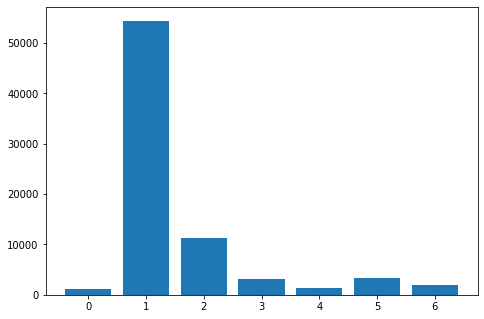

In [13]:
jan_df['count']=1 # to allow for counting the number of records with different passenger counts
jan_df_grouped = jan_df.groupby(by=["passenger_count"], as_index=False).sum()

# bar plot of passenger counts in jan 2019
passenger_counts = jan_df_grouped['passenger_count'].tolist()
counts = jan_df_grouped['count'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(passenger_counts,counts)
plt.savefig('../plots/taxi_outliers.png')
plt.show()

We can see from above there are records where passenger count = 0 --> must filter these

### Filter data, remove outliers and add date column for taxi data

In [16]:
# Filter data and remove outliers for each month 
# - where passenger count <=0 and trip distance <=0 miles or >=246.9 miles
# only include credit card payments, and accepted locationIDS < 264

from pyspark.sql import functions as F
from pyspark.sql.functions import *

required_cols = ('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'tip_amount', 'total_amount')


# filter each month separately and save data to curated data folder
files = ['2018-10.parquet', '2018-11.parquet', '2018-12.parquet', '2019-01.parquet', 
         '2019-02.parquet', '2019-03.parquet']

output_relative_dir = '../data/raw/tlc_data/' 

for file in files:
    target_dir = output_relative_dir + file
    taxi_month = spark.read.parquet(target_dir)
    # filter and remove outliers
    processed_month_data = taxi_month.select(*required_cols).where(
        (F.col('passenger_count') > 0) 
        & (F.col('trip_distance') > 0)
        & (F.col('trip_distance') < 246.9)
        & (F.col('PULocationID') < 264)
        & (F.col('DOLocationID') < 264)
        & (F.col('payment_type') == 1)
    )
    # add pickup_date column from tpep_datetime column
    processed_month_data1 = processed_month_data.withColumn("pickup_date", to_date(col('tpep_pickup_datetime')))
    
    # add pickup day of week
    processed_month_data2 = processed_month_data1.withColumn("day", date_format('tpep_pickup_datetime', 'EEEE'))
    
    # save file
    processed_month_data2.write.mode('overwrite').parquet(f'../data/curated/{file}')
    print(f'{file} processed')
    


2018-10.parquet processed


2018-11.parquet processed


2018-12.parquet processed


2019-01.parquet processed


2019-02.parquet processed


2019-03.parquet processed


## Join daily weather to yellow taxi records

In [17]:
import os

output_relative_dir = '../data/curated/'
target_dir = 'taxi_weather_data'

# check if it exists as it makedir will raise an error if it does exist
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    
# check if target dir exists
if not os.path.exists(output_relative_dir + target_dir):
        os.makedirs(output_relative_dir + target_dir)

In [18]:
# join taxi data for each month to daily weather and save data to curated data folder
files = ['2018-10.parquet', '2018-11.parquet', '2018-12.parquet', '2019-01.parquet', 
         '2019-02.parquet', '2019-03.parquet']

daily_weather_sdf = spark.read.parquet('../data/curated/daily_weather_data.parquet')

output_relative_dir = '../data/curated/' 

for file in files:
    target_dir = output_relative_dir + file
    taxi_month = spark.read.parquet(target_dir)
    
    # perform inner join by DATE for daily weather and pickup DATE for monthly taxi data
    weather_taxi_month_data = taxi_month.join(daily_weather_sdf,
                                              taxi_month.pickup_date == daily_weather_sdf.DATE,
                                              "inner")
    
    # save file
    weather_taxi_month_data.write.mode('overwrite').parquet(f'../data/curated/taxi_weather_data/{file}')
    print(f'{file} joined')


2018-10.parquet joined


2018-11.parquet joined


2018-12.parquet joined


2019-01.parquet joined


2019-02.parquet joined


2019-03.parquet joined


In [22]:
weather_taxi_month = spark.read.parquet('../data/curated/taxi_weather_data/2018-10.parquet').show()

+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+----------+------------+-----------+------+----------+------------+-----------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|tip_amount|total_amount|pickup_date|   day|      DATE|average_temp|average_dew_point|average_wind_speed|
+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+----------+------------+-----------+------+----------+------------+-----------------+------------------+
| 2018-10-01 00:05:35|  2018-10-01 00:19:38|            1.0|          6.1|       1.0|          50|         244|           1|      5.05|       25.35| 2018-10-01|Monday|2018-10-01|    201.0938|         180.9375|             49.25|
| 2018-10-01 00:19:14|  2018-10-01 00:31:54|            1.0|          2.6|       1.0